In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

c:\Users\HoYeon\Github\tickai\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_ds_feat = pd.read_csv('../../data/processed_train_feat.csv', index_col=0)
train_ds_targ = pd.read_csv('../../data/processed_train_targ.csv', index_col=0)

test_ds_feat = pd.read_csv('../../data/processed_test_feat.csv', index_col=0)
test_ds_targ = pd.read_csv('../../data/processed_test_targ.csv', index_col=0)

In [3]:
num_feat = len(train_ds_feat.columns)
num_feat

20

In [4]:
train_high = train_ds_targ.iloc[:, 0].to_numpy().reshape(len(train_ds_feat), 1)
train_low = train_ds_targ.iloc[:, 1].to_numpy().reshape(len(train_ds_feat), 1)

test_high = test_ds_targ.iloc[:, 0].to_numpy().reshape(len(test_ds_feat), 1)
test_low = test_ds_targ.iloc[:, 1].to_numpy().reshape(len(test_ds_feat), 1)

In [5]:
train_ds_feat.values

array([[2.68532694e-01, 2.68708727e-01, 6.75717258e-02, ...,
        6.79727206e-01, 3.02969915e-02, 7.84023805e-04],
       [2.60069134e-01, 2.60247204e-01, 6.14956228e-02, ...,
        6.64474882e-01, 3.01618591e-02, 7.52935627e-04],
       [2.67569832e-01, 2.69440327e-01, 6.09170495e-02, ...,
        6.81813216e-01, 3.02354721e-02, 7.80413565e-04],
       ...,
       [2.70650991e-01, 2.40176354e-01, 4.74061714e-02, ...,
        6.91104025e-01, 3.58836894e-02, 6.65688158e-04],
       [2.33263044e-01, 2.30848463e-01, 4.59088151e-02, ...,
        6.88484807e-01, 4.17727263e-02, 6.31792015e-04],
       [2.40426741e-01, 2.36133305e-01, 5.33002514e-02, ...,
        6.88763116e-01, 4.80298280e-02, 6.38009651e-04]])

In [6]:
class MyDataset(Dataset):
    def __init__(self, feat, targ):
        self.feat = feat.values
        self.targ = targ
        
    def __len__(self):
        return len(self.feat)
    
    def __getitem__(self, idx):
        feat = torch.FloatTensor(self.feat[idx])
        targ = torch.FloatTensor(self.targ[idx])
        return feat, targ

In [23]:
train_ds = MyDataset(train_ds_feat, train_high)
test_ds = MyDataset(test_ds_feat, test_high)

train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, input_size * 4),
            nn.ReLU(),
            nn.Linear(input_size * 4, input_size * 4),
            nn.ReLU(),
            nn.Linear(input_size * 4, output_size)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(num_feat, 1).to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=80, bias=True)
    (3): ReLU()
    (4): Linear(in_features=80, out_features=1, bias=True)
  )
)


In [26]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [61]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_loss / size

In [62]:
epochs = 1000
train_loss = np.zeros(epochs)

In [63]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss[t] = train(train_dl, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.000283  [    0/ 1485]
loss: 0.000049  [  400/ 1485]
loss: 0.000289  [  800/ 1485]
loss: 0.000126  [ 1200/ 1485]
Epoch 2
-------------------------------
loss: 0.000172  [    0/ 1485]
loss: 0.000129  [  400/ 1485]
loss: 0.000696  [  800/ 1485]
loss: 0.000125  [ 1200/ 1485]
Epoch 3
-------------------------------
loss: 0.005066  [    0/ 1485]
loss: 0.001674  [  400/ 1485]
loss: 0.000522  [  800/ 1485]
loss: 0.000475  [ 1200/ 1485]
Epoch 4
-------------------------------
loss: 0.000278  [    0/ 1485]
loss: 0.000092  [  400/ 1485]
loss: 0.000100  [  800/ 1485]
loss: 0.000834  [ 1200/ 1485]
Epoch 5
-------------------------------
loss: 0.000144  [    0/ 1485]
loss: 0.000164  [  400/ 1485]
loss: 0.008605  [  800/ 1485]
loss: 0.000085  [ 1200/ 1485]
Epoch 6
-------------------------------
loss: 0.000238  [    0/ 1485]
loss: 0.000160  [  400/ 1485]
loss: 0.000286  [  800/ 1485]
loss: 0.000319  [ 1200/ 1485]
Epoch 7
-------------------------------


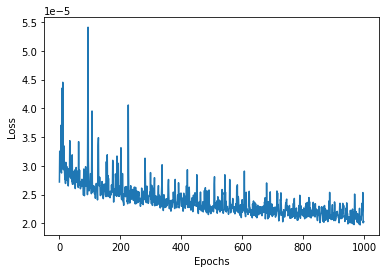

In [64]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [65]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    data = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            data.append([y.item(), pred.item(), y.item()-pred.item()])
            print(f"targ={y.item():.6f}\tpred={pred.item():.6f}\tdiff={(y.item()-pred.item())*100:2.2f}%")
    test_loss /= num_batches
    print(f"test loss = {test_loss:.6f}")
    return np.array(data)

In [66]:
data = test(test_dl, model, loss_fn)

targ=0.024874	pred=0.032503	diff=-0.76%
targ=0.010634	pred=0.018335	diff=-0.77%
targ=0.029104	pred=0.048998	diff=-1.99%
targ=0.053418	pred=0.056149	diff=-0.27%
targ=0.025415	pred=0.038309	diff=-1.29%
targ=0.008085	pred=0.011076	diff=-0.30%
targ=0.059499	pred=0.031420	diff=2.81%
targ=0.026756	pred=0.055175	diff=-2.84%
targ=0.023326	pred=0.028985	diff=-0.57%
targ=0.016233	pred=0.020912	diff=-0.47%
targ=0.004886	pred=0.011263	diff=-0.64%
targ=0.142595	pred=0.327800	diff=-18.52%
targ=0.012138	pred=0.025238	diff=-1.31%
targ=0.046568	pred=0.041058	diff=0.55%
targ=0.031258	pred=0.041976	diff=-1.07%
targ=0.028868	pred=0.041463	diff=-1.26%
targ=0.007464	pred=0.017598	diff=-1.01%
targ=0.058964	pred=0.056913	diff=0.21%
targ=0.008783	pred=0.017855	diff=-0.91%
targ=0.012975	pred=0.008938	diff=0.40%
targ=0.073187	pred=0.067708	diff=0.55%
targ=0.043330	pred=0.033625	diff=0.97%
targ=0.284638	pred=0.296213	diff=-1.16%
targ=0.093891	pred=0.079420	diff=1.45%
targ=0.009308	pred=0.028361	diff=-1.91%
targ=0

In [67]:
data

array([[ 0.02487431,  0.03250302, -0.00762871],
       [ 0.0106336 ,  0.01833466, -0.00770106],
       [ 0.02910434,  0.04899824, -0.0198939 ],
       ...,
       [ 0.01777936,  0.00743367,  0.01034569],
       [ 0.08155665,  0.06867357,  0.01288307],
       [ 0.01200311,  0.01863571, -0.0066326 ]])

In [68]:
test_result = pd.DataFrame(data=data, columns=["Target", "Predict", "Diff"])
test_result.sort_values(by=["Diff"], ascending=False)

,Target,Predict,Diff
185,0.491507,0.135487,0.356020
1113,0.316463,0.141014,0.175449
594,0.491732,0.374649,0.117083
122,0.184758,0.069974,0.114784
711,0.126466,0.023776,0.102689
...,...,...,...
930,0.036219,0.116858,-0.080639
286,0.816662,0.908386,-0.091724
574,0.082522,0.188529,-0.106007
1158,0.871111,0.977786,-0.106675
